In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

np.random.seed(123)
torch.manual_seed(123)

import math
from sklearn.linear_model import LinearRegression

# Use some real data: `run-pgdl-da`

In [2]:
data = np.load("../../run-pgdl-da/2_model_prep/out/data_train[1985-05-01.2021-04-14]_1573.npz", allow_pickle = True)

In [3]:
# Usually 31 ensembles, over many many days, 1 target variable
data['obs_trn'].shape

(31, 13132, 1)

In [4]:
# Let's just use 1 ensemble and the last 2000 days (which are NaN free)
x = torch.from_numpy(data['x_trn_fine']).float()[0, -2000:]
y = torch.from_numpy(data['obs_trn']).float()[0, -2000:]

y = (y - y.mean()) / y.std()

x.shape, y.shape

(torch.Size([2000, 6]), torch.Size([2000, 1]))

# Define a simple model

In [5]:
class ANN(torch.nn.Module):
    
    def __init__(self):
        super(ANN, self).__init__()
        self.fc1 = torch.nn.Linear(x.shape[1], 100)
        self.fc2 = torch.nn.Linear(100, 1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return(x)

# Make it
model = ANN()

In [6]:
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

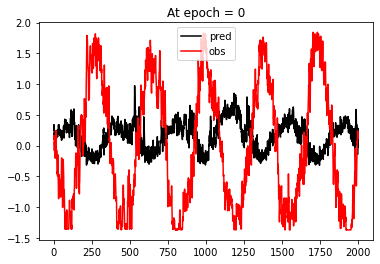

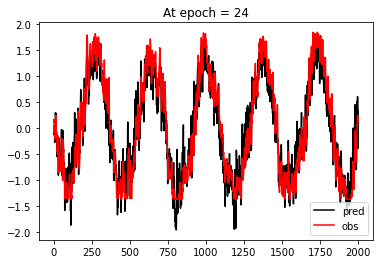

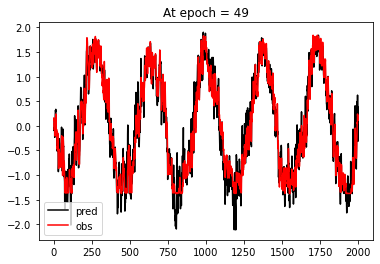

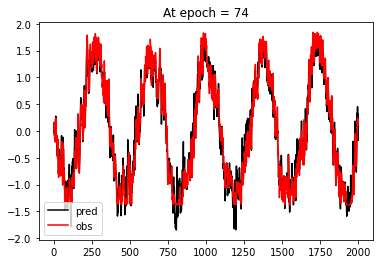

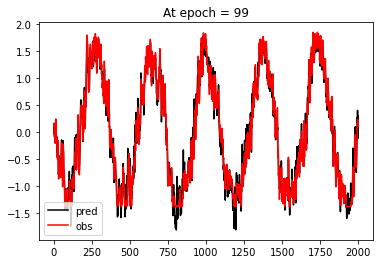

In [7]:
for i in range(100):
    out = model(x)
    loss = loss_fn(out, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (i+1) % 25 == 0 or i == 0:
        plt.plot(out.detach(), color = 'black', label = 'pred')
        plt.plot(y, color = 'red', label = 'obs')
        plt.legend()
        plt.title('At epoch = ' + str(i))
        plt.show()
        plt.pause(0.001)

# Apply custom SHAP, averaging by mask type

In [8]:
def weighting_kernel(M, num_nonzero_z):
    if num_nonzero_z == 0 or num_nonzero_z == M:
        out = 10000
    else:
        numerator = (M - 1)

        denom_1 = math.comb(M, num_nonzero_z)
        denom_2 = num_nonzero_z
        denom_3 = (M - num_nonzero_z)

        out = numerator / (denom_1 * denom_2 * denom_3)
    return(out)

In [9]:
%%time

whole_x = x.clone()

g_preds = []
g_weights = []
g_bias = []

for instance in range(x.shape[0]):
    x_to_explain = x[[instance]]
        
    # defining environment variables for shaping
    num_vars = x.shape[-1]
    n_samples = 2 * num_vars + 2048

    # structures to store random masks and associated predictions
    all_masks = np.zeros([n_samples, num_vars])
    #all_preds = np.zeros([n_samples, n_segs, seq_len, 1])
    all_preds = np.zeros([n_samples, 1])
    all_weights = np.zeros([n_samples, 1])

    # for many samples...
    for sample_i in range(n_samples):
        # generate a random mask for features to "remove" and store it
        mask = np.random.binomial(1, 0.5, num_vars)
        all_masks[sample_i] = mask

        ref_x = x_to_explain.numpy().copy()
        cur_x = ref_x.copy()
        # select a random year to fill removed variables with
        #rand_year = np.random.choice(22)
        rand_day = np.random.choice(2000)
        cur_x[:, ~mask.astype(bool)] = whole_x[rand_day, ~mask.astype(bool)]

        # get associated predictions and store
        cur_y_hat = model(torch.from_numpy(cur_x).float())
        all_preds[sample_i] = cur_y_hat.detach().numpy()

        # get associated weights
        all_weights[sample_i] = weighting_kernel(num_vars, np.sum(mask)) 
        
    linear_in = all_masks
    linear_target = all_preds

    weighted_linear_model = LinearRegression()
    weighted_linear_model.fit(linear_in, linear_target, all_weights.flatten())
        
        
    g_preds.append(weighted_linear_model.intercept_ + np.cumsum(weighted_linear_model.coef_[0])[-1])
    g_weights.append(weighted_linear_model.coef_[0])
    g_bias.append(weighted_linear_model.intercept_.item())
    
    if instance % 100 == 0:
        print(instance)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
Wall time: 10min 49s


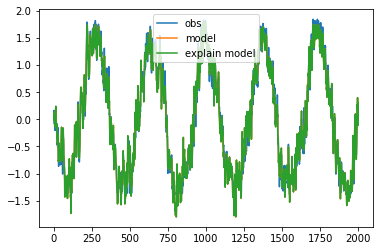

In [10]:
# sanity check for explanation models being good
plt.plot(y, label = 'obs')
plt.plot(model(x).detach().numpy(), label = 'model')
plt.plot(g_preds, label = 'explain model')
plt.legend();

In [11]:
g_weights = np.asarray(g_weights)
g_weights.shape

(2000, 6)

In [12]:
data['x_vars_trn']

array(['tmin', 'tmax', 'srad', 'dwallin_mean_temp',
       'reservoir_release_1444', 'reservoir_release_1566'], dtype='<U22')

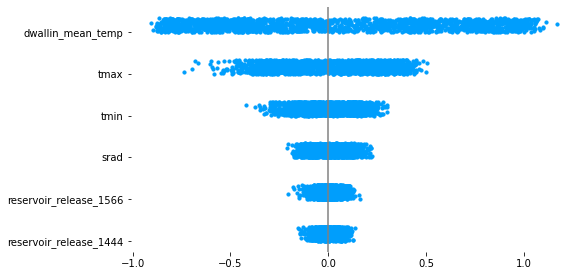

In [13]:
# view the distribution of SHAP values by variable
plt.figure(figsize = (16*1/2, 9*1/2))
plt.axvline(0, color = 'gray')
plt.box(False)

labels = []
count = 0

# sort the variables with the most important/sensitive at the top
for i in np.argsort(np.max(np.abs(g_weights), 0)):
    plt.scatter(g_weights[:, i],
                np.repeat(count, x.shape[0]) + np.random.uniform(size=x.shape[0])/3,
                color = '#009efc',
                s = 10)
    labels.append(data['x_vars_trn'][i])
    count += 1

plt.yticks(range(6), labels);

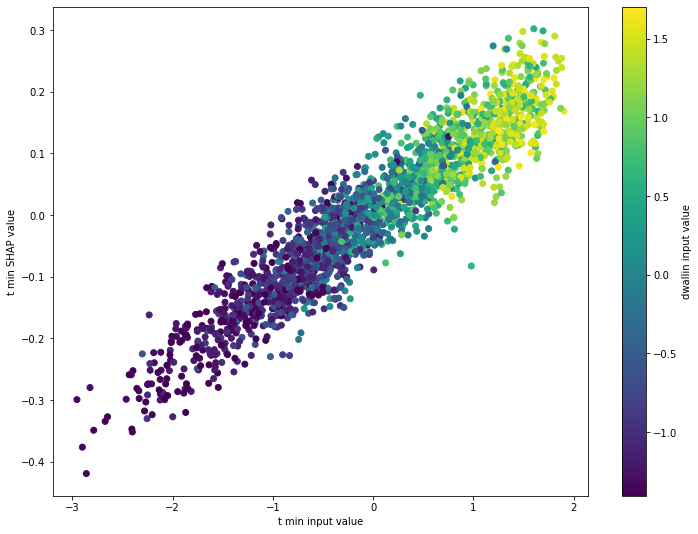

In [14]:
# view the interaction of one variables importance with another variables value
#   do the variables (tmin, dwallin) interact to determine ones (tmin) importance?
#   that does not appear stongly here.
plt.figure(figsize = (12, 9))
plt.scatter(x[:, 0].numpy(), g_weights[:, 0], c = x[:, 3].numpy())
plt.xlabel('t min input value')
plt.ylabel('t min SHAP value')
plt.colorbar(label = 'dwallin input value');

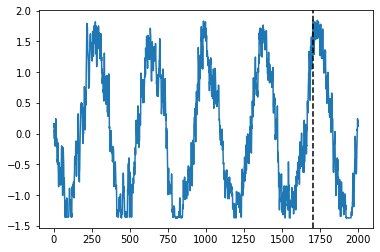

In [15]:
# show the time series for a specific prediction we'll look at below
plt.plot(y)
plt.axvline(np.argmax(y), color = 'black', linestyle = '--')

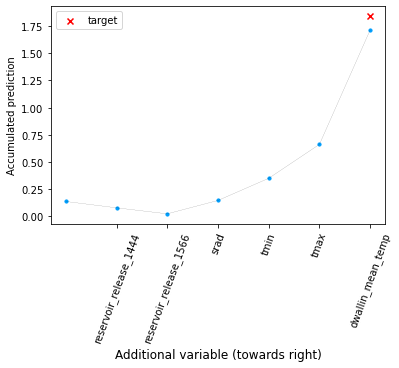

In [16]:
# getting the prediction with different variables included - sorted by later ones being more important
decision_ls = [g_bias[np.argmax(y)]]
for i in range(6):
    decision_ls.append((g_bias[np.argmax(y)] + np.cumsum(np.sort(g_weights[np.argmax(y)])))[i])
# plot the line
plt.plot(decision_ls, color = 'black', linewidth = 0.1)

# plotting associated points
plt.scatter(0, g_bias[np.argmax(y)], color = '#009efc', s = 10)
for i in range(6):
    plt.scatter(i+1,
                (g_bias[np.argmax(y)] + np.cumsum(np.sort(g_weights[np.argmax(y)])))[i],
                color = '#009efc',
                s = 10)
    
# label accordingly
plt.xticks(range(1, 7), data['x_vars_trn'][np.argsort(g_weights[np.argmax(y)])], rotation = 70)
plt.xlabel('Additional variable (towards right)', fontsize = 12)
plt.ylabel('Accumulated prediction')
# include reference - true observation
plt.scatter(6, y[np.argmax(y)], color = 'red', marker = 'x', label = 'target')
plt.legend();